In [ ]:
import sys
import cv2
import PIL
import math
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
upload_image = files.upload()

Saving scc.png to scc.png


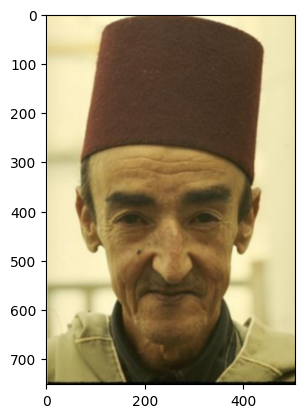

In [ ]:
img = cv2.imread("scc.png")
img_grayscale = cv2.imread("original.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [ ]:
laplacian_filter = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# laplacian_filter = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
laplacian_filter = np.array([[0, 0, -1, 0, 0],
                             [0, -1, -2, -1, 0],
                             [-1, -2, 17, -2, -1],
                             [0, -1, -2, -1, 0],
                             [0, 0, -1, 0, 0]])
laplacian_filter = np.array([[-1, -1, -1, -1, -1],
                             [-1, -1, -1, -1, -1],
                             [-1, -1, 24, -1, -1],
                             [-1, -1, -1, -1, -1],
                             [-1, -1, -1, -1, -1]])
# laplacian_filter = np.array([[-1, -1, -1, -1, -1, -1, -1],
#                              [-1, -1, -1, -1, -1, -1, -1],
#                              [-1, -1, -1, -1, -1, -1, -1],
#                              [-1, -1, -1, 48, -1, -1, -1],
#                              [-1, -1, -1, -1, -1, -1, -1],
#                              [-1, -1, -1, -1, -1, -1, -1],
#                              [-1, -1, -1, -1, -1, -1, -1]])
# laplacian_filter = np.array([[0, 0, 1, 0, 0],
#                              [0, 1, 2, 1, 0],
#                              [1, 2, -16, 2, 1],
#                              [0, 1, 2, 1, 0],
#                              [0, 0, 1, 0, 0]])
# laplacian_filter = np.array([
#                             [0, 0, 0, 1, 0, 0, 0],
#                             [0, 0, 1, 2, 1, 0, 0],
#                             [0, 1, 2, 4, 2, 1, 0],
#                             [1, 2, 4, -28, 4, 2, 1],
#                             [0, 1, 2, 4, 2, 1, 0],
#                             [0, 0, 1, 2, 1, 0, 0],
#                             [0, 0, 0, 1, 0, 0, 0]
#                         ])

In [ ]:
# laplacian_filter = np.array([[0, 0, 1, 0, 0],
#                              [0, 1, 2, 1, 0],
#                              [1, 2, -16, 2, 1],
#                              [0, 1, 2, 1, 0],
#                              [0, 0, 1, 0, 0]])

In [ ]:
box_filter = np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]])

In [ ]:
sobel_filter = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

In [ ]:
gaussian_filter = np.array([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]])

In [ ]:
def createLaplacianFiltet(filter_size):
  filter -1 * np.ones((filter_size, filter_size))
  filter[filter_size // 2, filter_size // 2] = filter_size * filter_size - 1
  return filter

In [ ]:
def createEMat(dim):
  iCenter, jCenter = dim // 2, dim // 2
  E = np.zeros((dim, dim))
  for i in range(dim):
    for j in range(dim):
      E[i, j] = np.sqrt((iCenter - i)**2 + (jCenter - j)**2)
  return E

In [ ]:
def BFs_or_BFr(e, sigma):
  return np.exp(-(e ** 2) / (2 * (sigma**2)))

In [ ]:
def one_step_bilateral_filter(img, i, j, k, filter_size):
  factor = filter_size // 2
  E_matrix = createEMat(filter_size)
  portion = img[i-factor:i+factor+1, j-factor:j+factor+1, k]
  D_matrix = portion - img[i,j,k]
  Bfs = BFs_or_BFr(E_matrix,1)
  Bfr = BFs_or_BFr(D_matrix,20)
  Multiplied_filter = np.multiply(Bfs,Bfr)
  W = np.sum(Multiplied_filter)
  return Multiplied_filter/W

In [ ]:
def conv3D(img, filter, i, j, k):
    val = 0
    factor = len(filter) // 2
    val += np.sum(img[i-factor:i+factor+1, j-factor:j+factor+1, k] * filter)
    return int(val)

In [ ]:
def conv(img, filter, i, j):
    val = 0
    factor = len(filter) // 2
    val += np.sum(img[i-factor:i+factor+1, j-factor:j+factor+1] * filter)
    return int(val)

In [ ]:
def takeMedian(img, i, j, filter_size):
    val = []
    factor = filter_size // 2
    for ii in range(i - factor, i + factor + 1):
        for jj in range(j - factor, j + factor + 1):
            val.append(img[ii, jj])
    val.sort()
    return val[len(val) // 2]

In [ ]:
def convolveMedian(img, filter_size):
    new_img = np.zeros(img.shape)
    length, width = img.shape
    factor = filter_size // 2
    for l in range(factor, length - factor):
        for w in range(factor, width - factor):
            new_img[l, w] = takeMedian(img, l, w, filter_size)
    return new_img.astype(int)

In [ ]:
def convolveLaplacian(img, filter, threshold=True):
  new_img = np.zeros(img.shape)
  length, width = img.shape
  factor = len(filter) // 2
  for l in range(factor, length-factor):
    for w in range(factor, width-factor):
      if threshold:
        new_img[l, w] = 255 if abs(conv(img, filter, l, w)) > 128 else 0
      else:
        new_img[l, w] = conv(img, filter, l, w)
  return new_img.astype(int)

In [ ]:
def convolveBillateral(img, filter_size):
  new_img = np.zeros(img.shape)
  length, width, channel = img.shape
  factor = filter_size // 2
  for l in range(factor, length-factor):
    for w in range(factor, width-factor):
      for c in range(3):
        billateral_filter = one_step_bilateral_filter(img, l, w, c, filter_size)
        new_img[l, w, c] = abs(conv3D(img, billateral_filter, l, w, c))
  return new_img.astype(int)

In [ ]:
def invert_img(img):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if(img[i][j] == 0):
        img[i][j] = 255
      elif(img[i][j] == 255):
        img[i][j] = 0
      else:
        print("error")
  return img

In [ ]:
def overlay(blurred, edge):
  blackimg = np.zeros(blurred.shape, dtype = int)
  for i in range(blurred.shape[0]):
    for j in range(blurred.shape[1]):
      if(edge[i][j] == 255):
        blackimg[i][j] = blurred[i][j]
  return blackimg

In [ ]:
def subplot(img1, img2):
  plt.subplot(1, 2, 1)
  plt.imshow(img1)  # Display the original image
  plt.title('Original Image')

  plt.subplot(1, 2, 2)
  plt.imshow(img2, cmap = 'gray')  # Display the processed image (new_img)
  plt.title('Processed Image')

In [ ]:
def cartoonize(img_path, filter, filter_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grayscale = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    blurred = convolveBillateral(img, filter_size)
    edge = convolveMedian(img_grayscale, filter_size=15)
    edge = convolveLaplacian(edge, filter)
    edge = invert_img(edge)
    return img, overlay(blurred, edge)

In [ ]:
laplacian_filter1 = np.array([[0, 0, -1, 0, 0],
                             [0, -1, -2, -1, 0],
                             [-1, -2, 17, -2, -1],
                             [0, -1, -2, -1, 0],
                             [0, 0, -1, 0, 0]])
laplacian_filter2 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
laplacian_filter3 = np.array([[1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, -48, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1],])


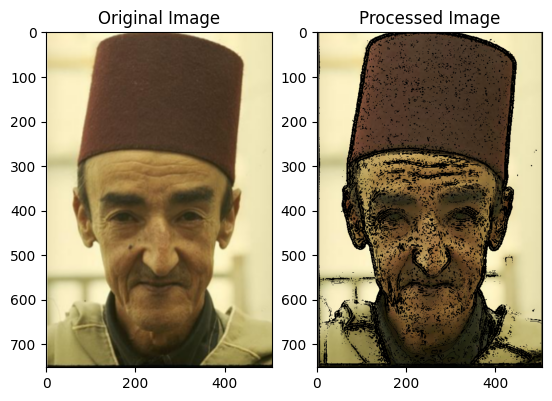

In [ ]:
img, cartoonized = cartoonize("scc.png", laplacian_filter3, filter_size=3)
subplot(img, cartoonized)

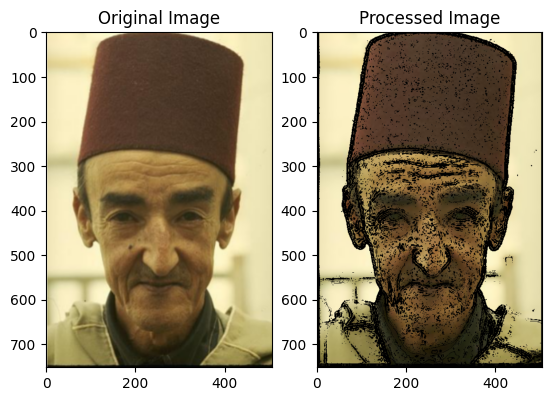

In [ ]:
img, cartoonized = cartoonize("scc.png", laplacian_filter3, filter_size=9)
subplot(img, cartoonized)

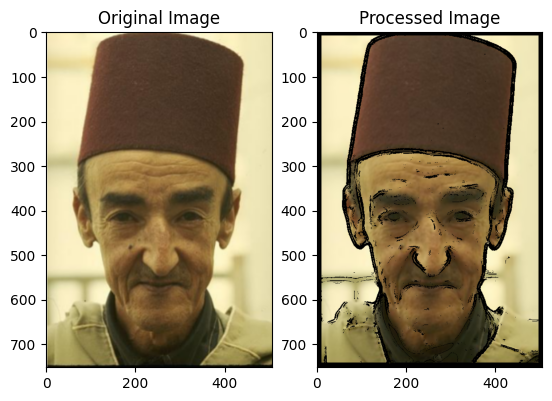

In [ ]:
img, cartoonized = cartoonize("scc.png", laplacian_filter3, filter_size=9)
subplot(img, cartoonized)

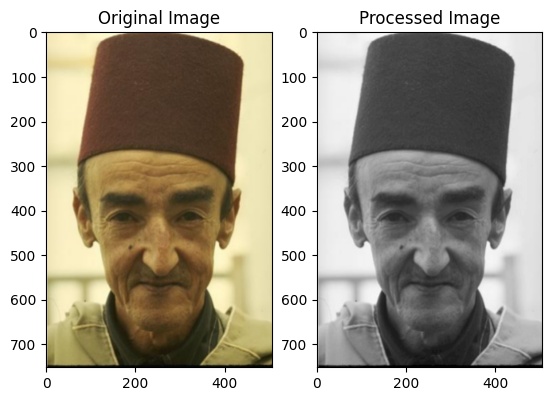

In [ ]:
img, cartoonized = cartoonize("scc.png", laplacian_filter3, filter_size=9)
subplot(img, cartoonized)

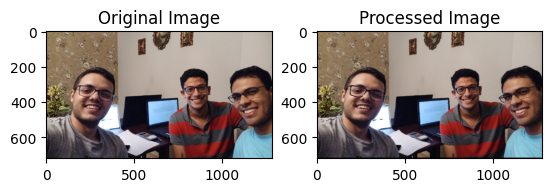

In [ ]:
img, cartoonized = cartoonize("/content/e7na.jpeg", laplacian_filter1)
subplot(img, cartoonized)

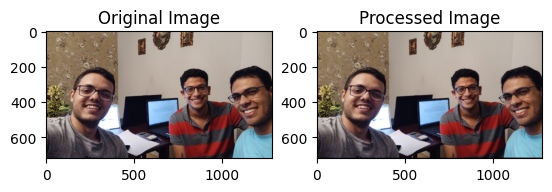

In [ ]:
img, cartoonized = cartoonize("/content/e7na.jpeg", laplacian_filter2)
subplot(img, cartoonized)

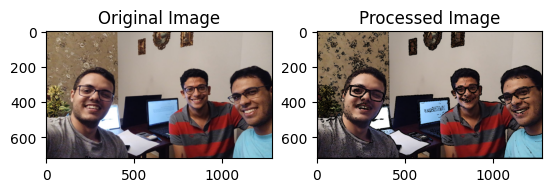

In [ ]:
img, cartoonized = cartoonize("/content/e7na.jpeg", laplacian_filter3)
subplot(img, cartoonized)

In [ ]:
img, cartoonized = cartoonize("/content/e7na.jpeg", laplacian_filter4)
subplot(img, cartoonized)

In [ ]:
img, cartoonized = cartoonize("/content/e7na.jpeg", laplacian_filter1)
subplot(img, cartoonized)

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter1)
subplot(img, cartoonized)

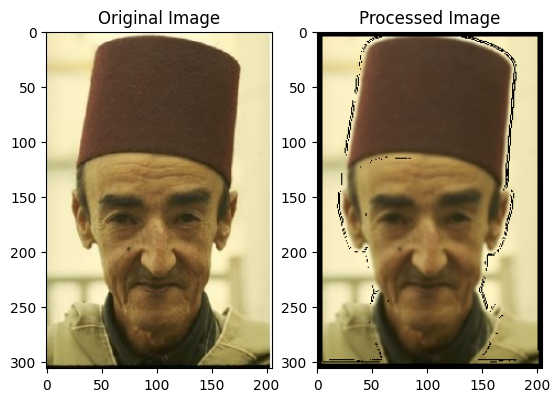

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter2, filter_size=9)
subplot(img, cartoonized)

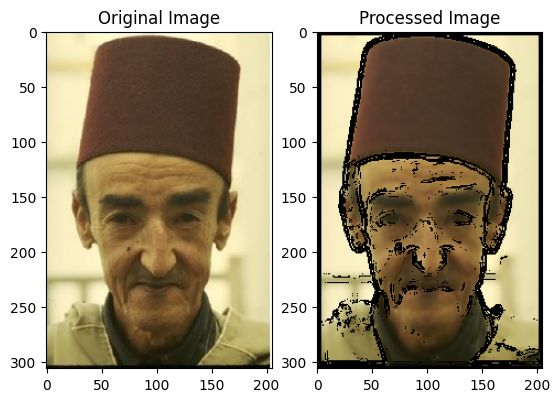

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter3, filter_size=5)
subplot(img, cartoonized)

In [ ]:
upload_image = files.upload()
img, cartoonized = cartoonize("/content/original.jpg", createLaplacianFiltet(filter_size=7), filter_size=9)
subplot(img, cartoonized)

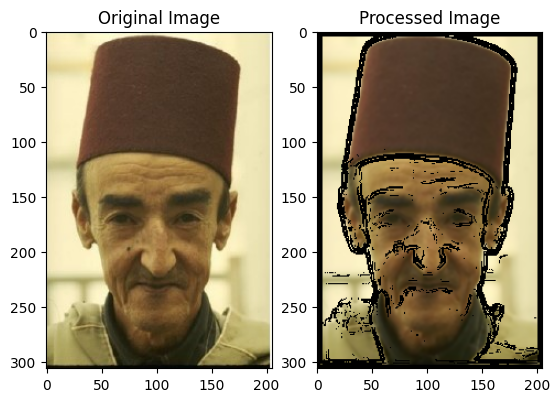

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter3, filter_size=7)
subplot(img, cartoonized)

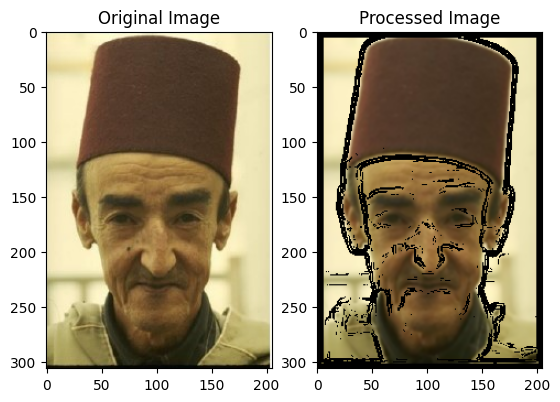

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter3, filter_size=9)
subplot(img, cartoonized)

In [ ]:
img, cartoonized = cartoonize("/content/original.jpg", laplacian_filter4)
subplot(img, cartoonized)

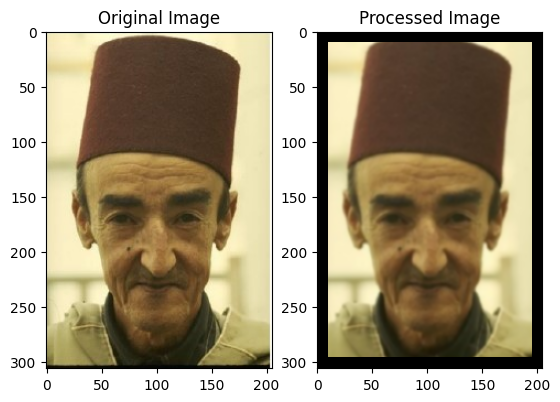

In [ ]:
blurred = convolveBillateral(img, filter_size=21)
subplot(img, blurred)

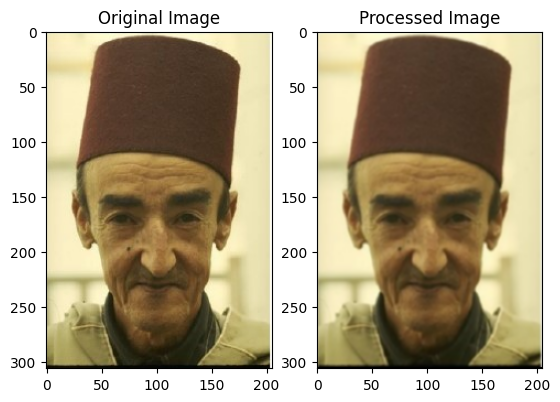

In [ ]:
blurred = convolveBillateral(img)
subplot(img, blurred)

<ipython-input-203-64550ab564f1>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return new_img.astype(np.int)
<ipython-input-204-213d7df00f77>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

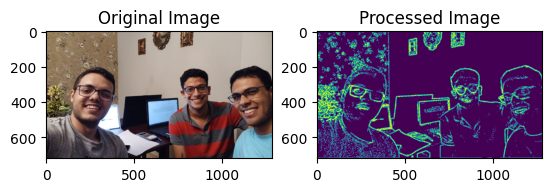

In [ ]:
edge = convolveMedian(img_grayscale, filter_size=3)
edge = convolveLaplacian(edge, laplacian_filter)
subplot(img, edge)

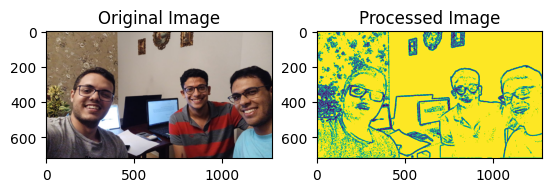

In [ ]:
edge = invert_img(edge)
subplot(img, edge)

## Part Two (Hough Transform)

In [ ]:
new_img = convolveMedian(img_grayscale, filter_size=3)

<ipython-input-468-64550ab564f1>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return new_img.astype(np.int)


In [ ]:
new_img_x = convolveLaplacian(new_img, sobel_filter, threshold=False)
new_img_y = convolveLaplacian(new_img, sobel_filter.T, threshold=False)

<ipython-input-469-213d7df00f77>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return new_img.astype(np.int)


In [ ]:
new_img_x

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,  262,   -1, ...,    0, -262,    0],
       [   0,  394,   -1, ...,   -1, -393,    0],
       ...,
       [   0,  230,   -4, ...,    6, -273,    0],
       [   0,  152,   -2, ...,    2, -184,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [ ]:
grad_mag = np.sqrt((new_img_x ** 2) + (new_img_y ** 2))

In [ ]:
grad_angle = (new_img_y / (new_img_x + sys.float_info.epsilon))

In [ ]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass

    return Z

In [ ]:
non_max_output = non_max_suppression(grad_mag, grad_angle)

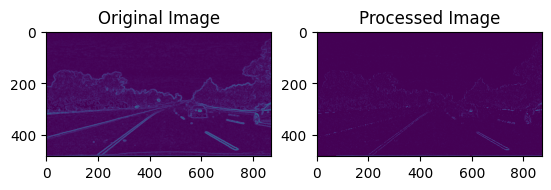

In [ ]:
subplot(grad_mag, non_max_output)

In [ ]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

In [ ]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

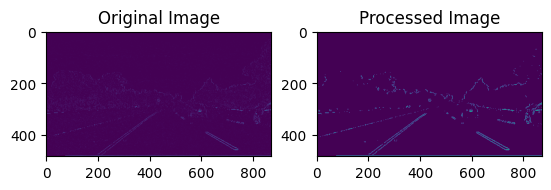

In [ ]:
res, weak, strong = threshold(non_max_output, lowThresholdRatio=5, highThresholdRatio=0.18)
hys_img = hysteresis(res, weak, strong)
subplot(non_max_output, hys_img)

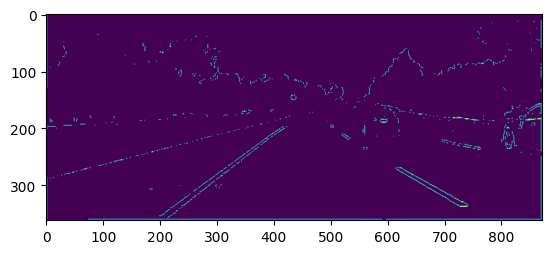

In [ ]:
plt.imshow(hys_img[120:, :])

In [ ]:
hys_img[:120, :] = 0

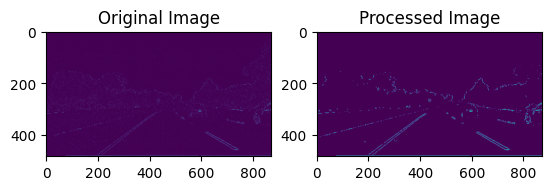

In [ ]:
subplot(non_max_output, hys_img)

In [ ]:
def hough(img):
  H = np.zeros((180, img.shape[0] + img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i, j] != 0:
        for theta in range(0, 180):
          row = i * np.cos(np.deg2rad(theta)) + j * np.sin(np.deg2rad(theta))
          H[theta, int(row)] += 1
  return H

In [ ]:
h = hough(hys_img)

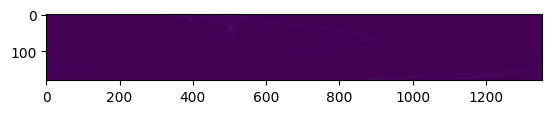

In [ ]:
plt.imshow(h)

In [ ]:
temp = []
for i in range(h.shape[0]):
  for j in range(h.shape[1]):
    if h[i, j] > 20:
      temp.append([i, j])

In [ ]:
for i in range(110,img.shape[0]):
  for j in range(10,img.shape[1]-10):
    for k in range(len(temp)):
      if (temp[k][1] == int(i * np.cos(np.deg2rad(temp[k][0])) + j * np.sin(np.deg2rad(temp[k][0])))):
        img[i][j][0] = 255
        img[i][j][1] = 0
        img[i][j][2] = 0

KeyboardInterrupt: ignored

In [ ]:
plt.imshow(img)